In [1]:
import warnings
warnings.filterwarnings("ignore")

import time
import numpy as np
import pandas as pd

from sklearn.model_selection import (cross_val_score, RepeatedStratifiedKFold, 
                                     RandomizedSearchCV, GridSearchCV, train_test_split)
import sklearn.metrics as metrics
from sklearn import preprocessing
from sklearn import feature_selection as fs
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import f_classif, SelectKBest, mutual_info_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestClassifier

from scipy import stats
import scipy.stats.distributions as dist
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from statsmodels.stats.proportion import proportions_ztest
from numpy import argsort

import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

pd.set_option('display.max_columns', None) 
pd.set_option('display.float_format', lambda x: '%.3f' % x)

sns.set_palette(sns.color_palette('rocket',10))

### Reading raw data

In [2]:
start_time = time.time()
data = pd.read_csv('bankdata.csv')
print("--- %s seconds ---" % (time.time() - start_time))

--- 12.277198553085327 seconds ---


### Data Exploration and Pre-processing

In [3]:
data.head()

,activity_year,lei,derived_msa-md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,derived_race,derived_sex,action_taken,purchaser_type,preapproval,loan_type,loan_purpose,lien_status,reverse_mortgage,open-end_line_of_credit,business_or_commercial_purpose,loan_amount,loan_to_value_ratio,interest_rate,rate_spread,hoepa_status,total_loan_costs,total_points_and_fees,origination_charges,discount_points,lender_credits,loan_term,prepayment_penalty_term,intro_rate_period,negative_amortization,interest_only_payment,balloon_payment,other_nonamortizing_features,property_value,construction_method,occupancy_type,manufactured_home_secured_property_type,manufactured_home_land_property_interest,total_units,multifamily_affordable_units,income,debt_to_income_ratio,applicant_credit_score_type,co-applicant_credit_score_type,applicant_ethnicity-1,applicant_ethnicity-2,applicant_ethnicity-3,applicant_ethnicity-4,applicant_ethnicity-5,co-applicant_ethnicity-1,co-applicant_ethnicity-2,co-applicant_ethnicity-3,co-applicant_ethnicity-4,co-applicant_ethnicity-5,applicant_ethnicity_observed,co-applicant_ethnicity_observed,applicant_race-1,applicant_race-2,applicant_race-3,applicant_race-4,applicant_race-5,co-applicant_race-1,co-applicant_race-2,co-applicant_race-3,co-applicant_race-4,co-applicant_race-5,applicant_race_observed,co-applicant_race_observed,applicant_sex,co-applicant_sex,applicant_sex_observed,co-applicant_sex_observed,applicant_age,co-applicant_age,applicant_age_above_62,co-applicant_age_above_62,submission_of_application,initially_payable_to_institution,aus-1,aus-2,aus-3,aus-4,aus-5,denial_reason-1,denial_reason-2,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
0,2019,E57ODZWZ7FF32TWEFA76,0,NaN,NaN,NaN,NC,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,Race Not Available,Male,8,0,1,1,1,1,2,2,2,985000.000,80.000,4.625,NaN,3,NaN,NaN,NaN,NaN,NaN,360.000,NaN,NaN,2,2,2,2,1305000.000,1,1,3,5,1,NaN,216.000,40,2,10,1.000,NaN,NaN,NaN,NaN,5.000,NaN,NaN,NaN,NaN,2,4,6.000,NaN,NaN,NaN,NaN,8.000,NaN,NaN,NaN,NaN,2,4,1,5,2,4,25-34,9999,No,NaN,1,1,5,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,0,0.000,0,0,0,0,0
1,2019,E57ODZWZ7FF32TWEFA76,0,NaN,NaN,NaN,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,White,Male,8,0,1,1,1,1,2,2,2,465000.000,80.000,4.750,NaN,3,NaN,NaN,NaN,NaN,NaN,360.000,NaN,NaN,2,2,2,2,755000.000,1,1,3,5,1,NaN,243.000,47,2,10,2.000,NaN,NaN,NaN,NaN,5.000,NaN,NaN,NaN,NaN,2,4,5.000,NaN,NaN,NaN,NaN,8.000,NaN,NaN,NaN,NaN,2,4,1,5,2,4,35-44,9999,No,NaN,1,1,1,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,0,0.000,0,0,0,0,0
2,2019,E57ODZWZ7FF32TWEFA76,0,NaN,NaN,NaN,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,Joint,Joint,7,0,1,1,1,1,2,2,2,165000.000,80.000,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,360.000,NaN,NaN,2,2,2,2,205000.000,1,1,3,5,1,NaN,71.000,50%-60%,1,9,2.000,NaN,NaN,NaN,NaN,2.000,NaN,NaN,NaN,NaN,2,2,5.000,NaN,NaN,NaN,NaN,22.000,NaN,NaN,NaN,NaN,2,2,1,2,2,2,65-74,55-64,Yes,No,1,1,1,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,0,0.000,0,0,0,0,0
3,2019,E57ODZWZ7FF32TWEFA76,0,NaN,NaN,NaN,NC,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,White,Joint,8,0,1,1,1,1,2,2,2,1415000.000,85.000,4.500,NaN,3,NaN,NaN,NaN,NaN,NaN,360.000,NaN,NaN,2,2,2,2,1655000.000,1,1,3,5,1,NaN,1110.000,30%-<36%,9,9,2.000,NaN,NaN,NaN,NaN,2.000,NaN,NaN,NaN,NaN,2,2,5.000,NaN,NaN,NaN,NaN,5.000,NaN,NaN,NaN,NaN,2,2,1,2,2,2,55-64,45-54,No,No,1,1,6,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,0,0.000,0,0,0,0,0
4,2019,E57ODZWZ7FF32TWEFA76,0,NaN,NaN,NaN,NC,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,White,Joint,7,0,1,1,1,1,2,2,2,905000.000,47.630,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,360.000,NaN,NaN,2,2,2,2,N

In [4]:
data.shape

(2110137, 99)

In [5]:
data.columns

Index(['activity_year', 'lei', 'derived_msa-md', 'state_code', 'county_code',
       'census_tract', 'conforming_loan_limit', 'derived_loan_product_type',
       'derived_dwelling_category', 'derived_ethnicity', 'derived_race',
       'derived_sex', 'action_taken', 'purchaser_type', 'preapproval',
       'loan_type', 'loan_purpose', 'lien_status', 'reverse_mortgage',
       'open-end_line_of_credit', 'business_or_commercial_purpose',
       'loan_amount', 'loan_to_value_ratio', 'interest_rate', 'rate_spread',
       'hoepa_status', 'total_loan_costs', 'total_points_and_fees',
       'origination_charges', 'discount_points', 'lender_credits', 'loan_term',
       'prepayment_penalty_term', 'intro_rate_period', 'negative_amortization',
       'interest_only_payment', 'balloon_payment',
       'other_nonamortizing_features', 'property_value', 'construction_method',
       'occupancy_type', 'manufactured_home_secured_property_type',
       'manufactured_home_land_property_interest', 'total_

In [6]:
data_refined = data[['derived_ethnicity',
                     'derived_race',
                     'derived_sex',
                     'loan_type',
                     'applicant_age',
                     'loan_amount',
                     'income',
                     'action_taken']]

In [7]:
data_refined.shape

(2110137, 8)

In [8]:
data_refined

,derived_ethnicity,derived_race,derived_sex,loan_type,applicant_age,loan_amount,income,action_taken
0,Hispanic or Latino,Race Not Available,Male,1,25-34,985000.000,216.000,8
1,Not Hispanic or Latino,White,Male,1,35-44,465000.000,243.000,8
2,Not Hispanic or Latino,Joint,Joint,1,65-74,165000.000,71.000,7
3,Not Hispanic or Latino,White,Joint,1,55-64,1415000.000,1110.000,8
4,Not Hispanic or Latino,White,Joint,1,25-34,905000.000,277.000,7
...,...,...,...,...,...,...,...,...
2110132,Not Hispanic or Latino,White,Male,1,35-44,225000.000,140.000,1
2110133,Not Hispanic or Latino,Black or African American,Female,3,65-74,285000.000,50.000,4
2110134,Ethnicity Not Available,Race Not Available,Sex Not Available,2,25-34,215000.000,61.000,4
2110135,Not Hispanic or Latino,White,Joint,1,55-64,485000.000,222.000,1


In [9]:
data_refined['action_taken'].value_counts()

1    743230
6    608412
3    447656
4    213050
5     65777
2     22509
8      5800
7      3703
Name: action_taken, dtype: int64

As only data where a completed loan was approved or denied is pertinent to this investigation, only the observations where either of these outcomes was whitnessed will be used in this investigation

In [10]:
groups = data_refined.groupby(['derived_sex','derived_race'])

In [11]:
groups.first()

derived_ethnicity  \
derived_sex       derived_race                                                         
Female            2 or more minority races                    Not Hispanic or Latino   
                  American Indian or Alaska Native                Hispanic or Latino   
                  Asian                                       Not Hispanic or Latino   
                  Black or African American                   Not Hispanic or Latino   
                  Free Form Text Only                             Hispanic or Latino   
                  Joint                                       Not Hispanic or Latino   
                  Native Hawaiian or Other Pacific Islander   Not Hispanic or Latino   
                  Race Not Available                         Ethnicity Not Available   
                  White                                       Not Hispanic or Latino   
Joint             2 or more minority races                    Not Hispanic or Latino   
                  American Indian or Alaska Native            Not Hispanic or Latino   
                  Asian                                       Not Hispanic or Latino   
                  Black or African American                   Not Hispanic or Latino   
                  Free Form Text Only                         Not Hispanic or Latino   
                  Joint                                       Not Hispanic or Latino   
                  Native Hawaiian or Other Pacific Islander   Not Hispanic or Latino   
                  Race Not Available                              Hispanic or Latino   
                  White                                       Not Hispanic or Latino   
Male              2 or more minority races                    Not Hispanic or Latino   
                  American Indian or Alaska Native                Hispanic or Latino   
                  Asian                                       Not Hispanic or Latino   
                  Black or African American                   Not Hispanic or Latino   
                  Free Form Text Only                         Not Hispanic or Latino   
                  Joint                                       Not Hispanic or Latino   
                  Native Hawaiian or Other Pacific Islander  Ethnicity Not Available   
                  Race Not Available                              Hispanic or Latino   
                  White                                       Not Hispanic or Latino   
Sex Not Available 2 or more minority races                   Ethnicity Not Available   
                  American Indian or Alaska Native           Ethnicity Not Available   
                  Asian                                       Not Hispanic or Latino   
                  Black or African American                  Ethnicity Not Available   
                  Free Form Text Only                             Hispanic or Latino   
                  Joint                                      Ethnicity Not Available   
                  Native Hawaiian or Other Pacific Islander  Ethnicity Not Available   
                  Race Not Available                         Ethnicity Not Available   
                  White                                       Not Hispanic or Latino   

                                                             loan_type  \
derived_sex       derived_race                                           
Female            2 or more minority races                           1   
                  American Indian or Alaska Native                   1   
                  Asian                                              1   
                  Black or African American                          1   
                  Free Form Text Only                                1   
                  Joint                                              1   
                  Native Hawaiian or Other Pacific Islander          1   
                  Race Not Available                    

In [12]:
data_refined

,derived_ethnicity,derived_race,derived_sex,loan_type,applicant_age,loan_amount,income,action_taken
0,Hispanic or Latino,Race Not Available,Male,1,25-34,985000.000,216.000,8
1,Not Hispanic or Latino,White,Male,1,35-44,465000.000,243.000,8
2,Not Hispanic or Latino,Joint,Joint,1,65-74,165000.000,71.000,7
3,Not Hispanic or Latino,White,Joint,1,55-64,1415000.000,1110.000,8
4,Not Hispanic or Latino,White,Joint,1,25-34,905000.000,277.000,7
...,...,...,...,...,...,...,...,...
2110132,Not Hispanic or Latino,White,Male,1,35-44,225000.000,140.000,1
2110133,Not Hispanic or Latino,Black or African American,Female,3,65-74,285000.000,50.000,4
2110134,Ethnicity Not Available,Race Not Available,Sex Not Available,2,25-34,215000.000,61.000,4
2110135,Not Hispanic or Latino,White,Joint,1,55-64,485000.000,222.000,1


In [13]:
data_refined.head(9)

,derived_ethnicity,derived_race,derived_sex,loan_type,applicant_age,loan_amount,income,action_taken
0,Hispanic or Latino,Race Not Available,Male,1,25-34,985000.000,216.000,8
1,Not Hispanic or Latino,White,Male,1,35-44,465000.000,243.000,8
2,Not Hispanic or Latino,Joint,Joint,1,65-74,165000.000,71.000,7
3,Not Hispanic or Latino,White,Joint,1,55-64,1415000.000,1110.000,8
4,Not Hispanic or Latino,White,Joint,1,25-34,905000.000,277.000,7
5,Not Hispanic or Latino,White,Male,1,35-44,205000.000,83.000,8
6,Not Hispanic or Latino,White,Joint,1,35-44,525000.000,175.000,7
7,Not Hispanic or Latino,Asian,Female,1,25-34,625000.000,291.000,8
8,Not Hispanic or Latino,White,Joint,1,45-54,3235000.000,3140.000,8


In [14]:
data_refined['action_taken'].value_counts()

1    743230
6    608412
3    447656
4    213050
5     65777
2     22509
8      5800
7      3703
Name: action_taken, dtype: int64

In [15]:
data_refined['action_taken'].replace([2,6],1, inplace = True)


In [16]:
data_refined['action_taken'].replace(3,0, inplace = True)
data_refined['action_taken'].value_counts()

1    1374151
0     447656
4     213050
5      65777
8       5800
7       3703
Name: action_taken, dtype: int64

In [17]:
action_vals = [0,1]
data_refined = data_refined[data_refined.action_taken.isin(action_vals)]

In [18]:
data_refined['action_taken'].value_counts()

1    1374151
0     447656
Name: action_taken, dtype: int64

In [19]:
data_refined.shape

(1821807, 8)

In [20]:
data_refined.head()

,derived_ethnicity,derived_race,derived_sex,loan_type,applicant_age,loan_amount,income,action_taken
25,Ethnicity Not Available,Race Not Available,Sex Not Available,1,25-34,305000.000,75.000,1
33,Ethnicity Not Available,Race Not Available,Sex Not Available,1,35-44,525000.000,217.000,1
36,Not Hispanic or Latino,Asian,Male,1,35-44,305000.000,50.000,0
38,Not Hispanic or Latino,White,Male,1,55-64,1005000.000,866.000,1
40,Ethnicity Not Available,Race Not Available,Sex Not Available,1,25-34,125000.000,45.000,1


In [21]:
data_refined['derived_sex'].value_counts()

Joint                694494
Male                 566698
Female               364384
Sex Not Available    196231
Name: derived_sex, dtype: int64

In [22]:
data_refined['derived_ethnicity'].value_counts()

Not Hispanic or Latino     1291305
Ethnicity Not Available     299273
Hispanic or Latino          187960
Joint                        39670
Free Form Text Only           3599
Name: derived_ethnicity, dtype: int64

In [23]:
data_refined = data_refined[~data_refined.derived_ethnicity.str.contains('Ethnicity Not Available')]
data_refined = data_refined[~data_refined.derived_ethnicity.str.contains('Free Form Text Only')]

In [24]:
data_refined['derived_ethnicity'].value_counts()

Not Hispanic or Latino    1291305
Hispanic or Latino         187960
Joint                       39670
Name: derived_ethnicity, dtype: int64

In [25]:
data_refined['derived_race'].value_counts()
data_refined = data_refined[~data_refined.derived_race.str.contains('Race Not Available')]
data_refined = data_refined[~data_refined.derived_race.str.contains('Free Form Text Only')]
data_refined['derived_race'].value_counts()

White                                        1153989
Asian                                         162214
Black or African American                      90407
Joint                                          35931
Native Hawaiian or Other Pacific Islander       9034
American Indian or Alaska Native                8706
2 or more minority races                        2913
Name: derived_race, dtype: int64

In [26]:
data_refined['derived_sex'].value_counts()
data_refined = data_refined[~data_refined.derived_sex.str.contains('Sex Not Available')]
data_refined['derived_sex'].value_counts()

Joint     632177
Male      502302
Female    327072
Name: derived_sex, dtype: int64

In [27]:
data_refined.isna().sum()

derived_ethnicity        0
derived_race             0
derived_sex              0
loan_type                0
applicant_age            0
loan_amount              0
income               48922
action_taken             0
dtype: int64

In [28]:
data_refined = data_refined.dropna()

In [29]:
data_refined = data_refined[data_refined.income >= 0]

data_refined['income'].min()

0.0

In [30]:
data_refined['applicant_age'].value_counts()

35-44    338984
45-54    326212
55-64    266435
25-34    245144
65-74    155454
>74       57093
<25       22727
8888          2
Name: applicant_age, dtype: int64

In [31]:
data_refined = data_refined[data_refined.applicant_age != '8888']

In [32]:
data_refined['applicant_age'].value_counts()

35-44    338984
45-54    326212
55-64    266435
25-34    245144
65-74    155454
>74       57093
<25       22727
Name: applicant_age, dtype: int64

In [33]:
data_refined.describe()

,loan_type,loan_amount,income,action_taken
count,1412049.000,1412049.000,1412049.000,1412049.000
mean,1.046,296474.857,150.932,0.749
std,0.290,347720.337,707.848,0.434
min,1.000,5000.000,0.000,0.000
25%,1.000,105000.000,63.000,0.000
50%,1.000,205000.000,102.000,1.000
75%,1.000,365000.000,167.000,1.000
max,4.000,50005000.000,734000.000,1.000


In [34]:
data_refined.shape

(1412049, 8)

In [35]:
data_refined

,derived_ethnicity,derived_race,derived_sex,loan_type,applicant_age,loan_amount,income,action_taken
36,Not Hispanic or Latino,Asian,Male,1,35-44,305000.000,50.000,0
38,Not Hispanic or Latino,White,Male,1,55-64,1005000.000,866.000,1
41,Not Hispanic or Latino,Asian,Female,1,35-44,365000.000,157.000,1
43,Not Hispanic or Latino,Black or African American,Female,1,45-54,335000.000,105.000,1
46,Hispanic or Latino,White,Male,1,45-54,75000.000,60.000,1
...,...,...,...,...,...,...,...,...
2110128,Hispanic or Latino,White,Male,2,55-64,225000.000,66.000,1
2110130,Hispanic or Latino,White,Joint,2,25-34,565000.000,0.000,1
2110132,Not Hispanic or Latino,White,Male,1,35-44,225000.000,140.000,1
2110135,Not Hispanic or Latino,White,Joint,1,55-64,485000.000,222.000,1


In [36]:
data_refined

,derived_ethnicity,derived_race,derived_sex,loan_type,applicant_age,loan_amount,income,action_taken
36,Not Hispanic or Latino,Asian,Male,1,35-44,305000.000,50.000,0
38,Not Hispanic or Latino,White,Male,1,55-64,1005000.000,866.000,1
41,Not Hispanic or Latino,Asian,Female,1,35-44,365000.000,157.000,1
43,Not Hispanic or Latino,Black or African American,Female,1,45-54,335000.000,105.000,1
46,Hispanic or Latino,White,Male,1,45-54,75000.000,60.000,1
...,...,...,...,...,...,...,...,...
2110128,Hispanic or Latino,White,Male,2,55-64,225000.000,66.000,1
2110130,Hispanic or Latino,White,Joint,2,25-34,565000.000,0.000,1
2110132,Not Hispanic or Latino,White,Male,1,35-44,225000.000,140.000,1
2110135,Not Hispanic or Latino,White,Joint,1,55-64,485000.000,222.000,1


In [37]:
data_refined['derived_race'].value_counts()

White                                        1114310
Asian                                         157399
Black or African American                      86085
Joint                                          34428
Native Hawaiian or Other Pacific Islander       8778
American Indian or Alaska Native                8299
2 or more minority races                        2750
Name: derived_race, dtype: int64

In [38]:
data_refined.shape

(1412049, 8)

In [39]:
data_refined.columns

Index(['derived_ethnicity', 'derived_race', 'derived_sex', 'loan_type',
       'applicant_age', 'loan_amount', 'income', 'action_taken'],
      dtype='object')

In [40]:
data = data_refined.iloc[: , 0:]

In [41]:
data.head()

,derived_ethnicity,derived_race,derived_sex,loan_type,applicant_age,loan_amount,income,action_taken
36,Not Hispanic or Latino,Asian,Male,1,35-44,305000.000,50.000,0
38,Not Hispanic or Latino,White,Male,1,55-64,1005000.000,866.000,1
41,Not Hispanic or Latino,Asian,Female,1,35-44,365000.000,157.000,1
43,Not Hispanic or Latino,Black or African American,Female,1,45-54,335000.000,105.000,1
46,Hispanic or Latino,White,Male,1,45-54,75000.000,60.000,1


In [42]:
data.isna().sum()

derived_ethnicity    0
derived_race         0
derived_sex          0
loan_type            0
applicant_age        0
loan_amount          0
income               0
action_taken         0
dtype: int64

In [43]:
data.head()

,derived_ethnicity,derived_race,derived_sex,loan_type,applicant_age,loan_amount,income,action_taken
36,Not Hispanic or Latino,Asian,Male,1,35-44,305000.000,50.000,0
38,Not Hispanic or Latino,White,Male,1,55-64,1005000.000,866.000,1
41,Not Hispanic or Latino,Asian,Female,1,35-44,365000.000,157.000,1
43,Not Hispanic or Latino,Black or African American,Female,1,45-54,335000.000,105.000,1
46,Hispanic or Latino,White,Male,1,45-54,75000.000,60.000,1


In [44]:
data['action_taken'].value_counts()

1    1057548
0     354501
Name: action_taken, dtype: int64

In [45]:
data.describe()

,loan_type,loan_amount,income,action_taken
count,1412049.000,1412049.000,1412049.000,1412049.000
mean,1.046,296474.857,150.932,0.749
std,0.290,347720.337,707.848,0.434
min,1.000,5000.000,0.000,0.000
25%,1.000,105000.000,63.000,0.000
50%,1.000,205000.000,102.000,1.000
75%,1.000,365000.000,167.000,1.000
max,4.000,50005000.000,734000.000,1.000


Text(0, 0.5, 'Log Frequency')

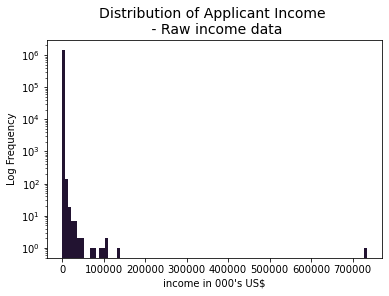

In [46]:
plt.hist(data['income'], bins = 100, log = True)
plt.title('Distribution of Applicant Income \n - Raw income data', fontsize=14)
plt.xlabel("income in 000's US$")
plt.ylabel('Log Frequency')

In [47]:
z_income = np.abs(stats.zscore(data['income']))
data = data[(z_income < 3)]

In [48]:
data.shape

(1409848, 8)

Text(0, 0.5, 'Log Frequency')

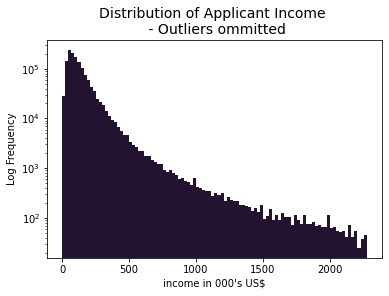

In [49]:
plt.hist(data['income'], bins = 100, log = True)
plt.title('Distribution of Applicant Income \n - Outliers ommitted', fontsize=14)
plt.xlabel("income in 000's US$")
plt.ylabel('Log Frequency')

In [50]:
data['income'].describe()

count   1409848.000
mean        143.391
std         155.188
min           0.000
25%          63.000
50%         102.000
75%         167.000
max        2274.000
Name: income, dtype: float64

Text(0, 0.5, 'Log Frequency')

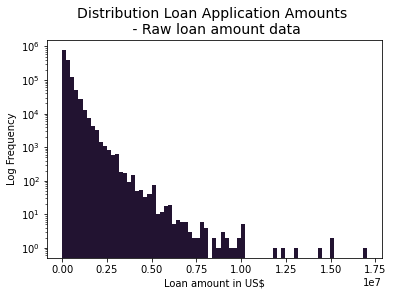

In [51]:
plt.hist(data['loan_amount'], bins = 75, log = True)
plt.title('Distribution Loan Application Amounts \n - Raw loan amount data', fontsize=14)
plt.xlabel("Loan amount in US$")
plt.ylabel('Log Frequency')

In [52]:
z_loan = np.abs(stats.zscore(data['loan_amount']))
data = data[(z_loan < 3)]
data.shape

(1383252, 8)

Text(0, 0.5, 'Log Frequency')

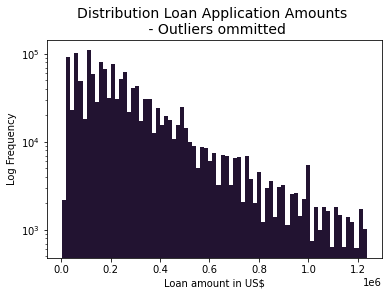

In [53]:
plt.hist(data['loan_amount'], bins = 75, log = True)
plt.title('Distribution Loan Application Amounts \n - Outliers ommitted', fontsize=14)
plt.xlabel("Loan amount in US$")
plt.ylabel('Log Frequency')

In [54]:
data['loan_amount'].describe()

count   1383252.000
mean     264141.653
std      219630.388
min        5000.000
25%      105000.000
50%      205000.000
75%      345000.000
max     1235000.000
Name: loan_amount, dtype: float64

In [55]:
data.columns

Index(['derived_ethnicity', 'derived_race', 'derived_sex', 'loan_type',
       'applicant_age', 'loan_amount', 'income', 'action_taken'],
      dtype='object')

In [56]:
print(data['derived_ethnicity'].dtype)
print(data['derived_race'].dtype)
print(data['derived_sex'].dtype)
print(data['loan_type'].dtype)
print(data['applicant_age'].dtype)
print(data['loan_amount'].dtype)
print(data['income'].dtype)
print(data['action_taken'].dtype)

object
object
object
int64
object
float64
float64
int64


In [57]:
data['loan_type'] = data['loan_type'].astype(object)
data['loan_type'].value_counts()

1    1344950
3      24247
2      12720
4       1335
Name: loan_type, dtype: int64

In [58]:
data['loan_type']

36         1
38         1
41         1
43         1
46         1
          ..
2110128    2
2110130    2
2110132    1
2110135    1
2110136    1
Name: loan_type, Length: 1383252, dtype: object

In [59]:
data_copy = data.copy()
data = data.drop(columns = 'action_taken')
target = data_copy['action_taken']

In [60]:
categorical_cols = data.columns[data.dtypes==object].tolist()
categorical_cols

['derived_ethnicity',
 'derived_race',
 'derived_sex',
 'loan_type',
 'applicant_age']

In [61]:
data.columns

Index(['derived_ethnicity', 'derived_race', 'derived_sex', 'loan_type',
       'applicant_age', 'loan_amount', 'income'],
      dtype='object')

In [62]:
obj_names = {0 : 'Derived Ethinicity',
             1 : 'Derived Race',
             2 : 'Derived Sex',
             3 : 'Loan Type',
             4 : 'Applicant Age'}

In [63]:
data['derived_ethnicity'].value_counts()

Not Hispanic or Latino    1196004
Hispanic or Latino         152070
Joint                       35178
Name: derived_ethnicity, dtype: int64

<Figure size 432x288 with 0 Axes>

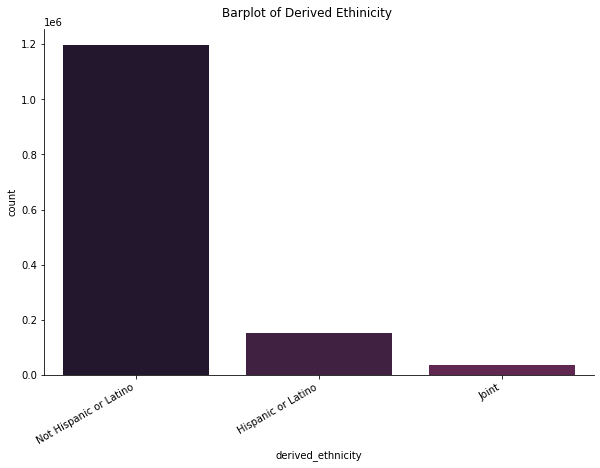

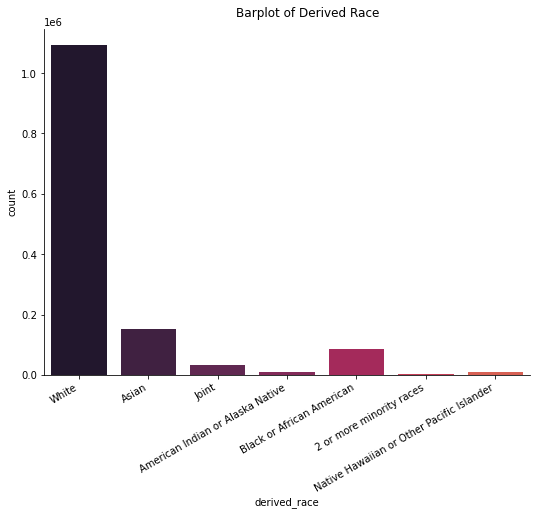

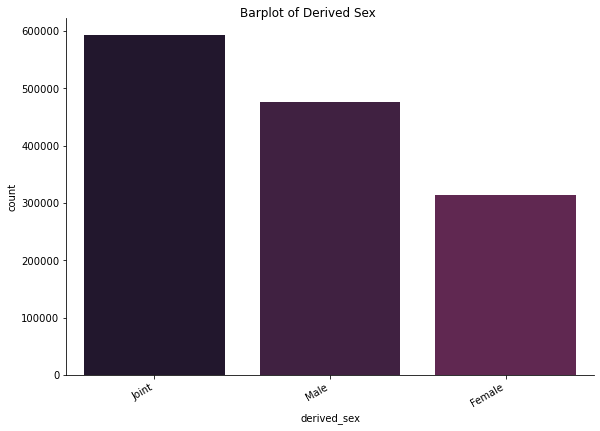

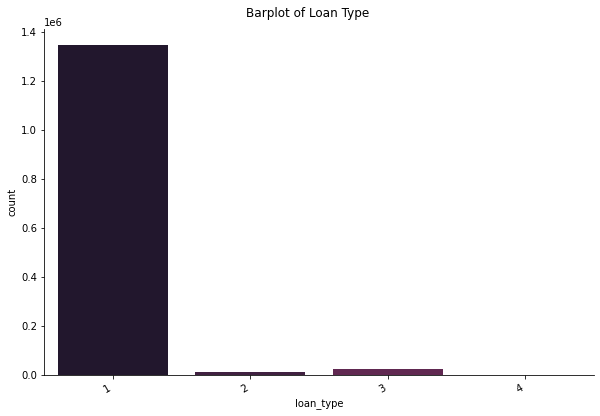

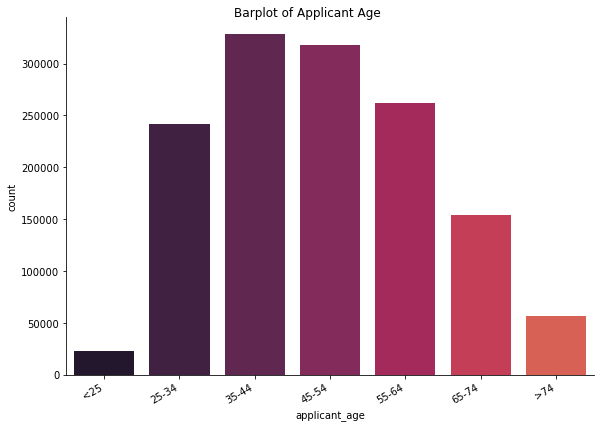

In [64]:
df1 = data.select_dtypes('O').sort_values(by='applicant_age')
i = 0
for i, col in enumerate(df1.columns):
    labels = df1[categorical_cols[i]].unique()
    plt.figure(i)
    if col=='applicant_age':
        g = sns.catplot(x='applicant_age', kind = "count", order=['<25','25-34','35-44','45-54','55-64','65-74','>74'], data=df1, legend_out = True, height = 5.5, aspect = 1.5)
        g.set_xticklabels(rotation=30, ha="right")
        plt.suptitle("Barplot of " + obj_names[i],  y = 1)
    else:
        g = sns.catplot(x=col, kind = "count", data=df1, legend_out = True, height = 5.5, aspect = 1.5)
        g.set_xticklabels(rotation=30, ha="right")
        plt.suptitle("Barplot of " + obj_names[i],  y = 1)
    i=i+1    

In [65]:
i = 0
for feature in categorical_cols:
    print(categorical_cols[i],'percentages')
    print(data[feature].value_counts(normalize=True)*100)
    print('\n')
    i = i+1

derived_ethnicity percentages
Not Hispanic or Latino   86.463
Hispanic or Latino       10.994
Joint                     2.543
Name: derived_ethnicity, dtype: float64


derived_race percentages
White                                       79.031
Asian                                       10.944
Black or African American                    6.203
Joint                                        2.396
Native Hawaiian or Other Pacific Islander    0.633
American Indian or Alaska Native             0.597
2 or more minority races                     0.197
Name: derived_race, dtype: float64


derived_sex percentages
Joint    42.894
Male     34.388
Female   22.719
Name: derived_sex, dtype: float64


loan_type percentages
1   97.231
3    1.753
2    0.920
4    0.097
Name: loan_type, dtype: float64


applicant_age percentages
35-44   23.728
45-54   22.984
55-64   18.942
25-34   17.507
65-74   11.110
>74      4.089
<25      1.641
Name: applicant_age, dtype: float64




In [66]:
t2 = pd.DataFrame(target, columns = ['action_taken'])

Text(0.5, 1, 'Barplot of  Target Feature')

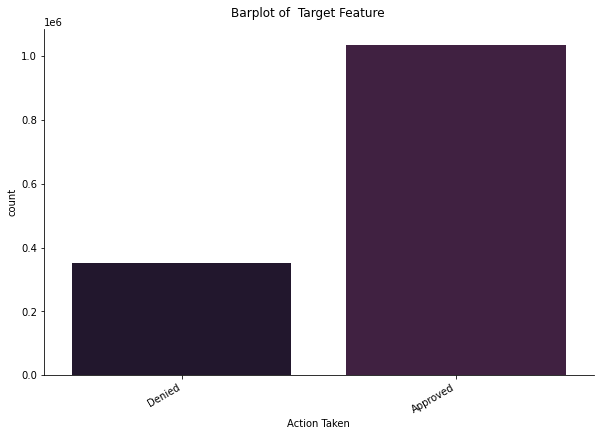

In [67]:
g2 = sns.catplot(x='action_taken', kind = "count", data=t2, 
                 legend_out = True, height = 5.5, aspect = 1.5)
g2.set_xticklabels(rotation=30, ha="right")
g2.set_xticklabels(['Denied','Approved'])
plt.xlabel('Action Taken')
plt.suptitle("Barplot of  Target Feature",  y = 1)

In [68]:
print(t2['action_taken'].value_counts(normalize=True)*100)

1   74.675
0   25.325
Name: action_taken, dtype: float64


Text(0.5, 1, 'Grouped Bar Chart of Loan Outcome \n by Derived Sex')

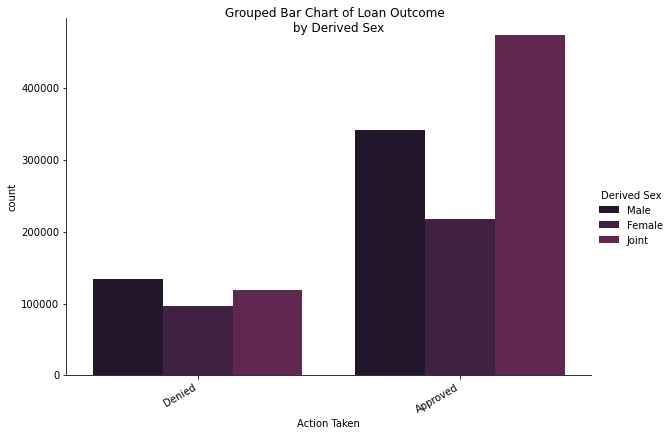

In [69]:
g3 = sns.catplot(x='action_taken', kind = "count", data=data_copy, 
                 legend_out = True, height = 5.5, aspect = 1.5, hue = 'derived_sex')
g3.set_xticklabels(rotation=30, ha="right")
g3.set_xticklabels(['Denied','Approved'])
g3._legend.set_title('Derived Sex')
plt.xlabel('Action Taken')
plt.suptitle("Grouped Bar Chart of Loan Outcome \n by Derived Sex",  y = 1)

In [70]:
cont_data = data_copy.copy()
cont_data.shape
cont_data['action_taken'].astype('O')
cont_data['action_taken'] = cont_data['action_taken'].map({1:'Approved',0:'Denied'})

Text(0.5, 1, 'Grouped Bar Chart of Loan Outcome \n by Derived Race')

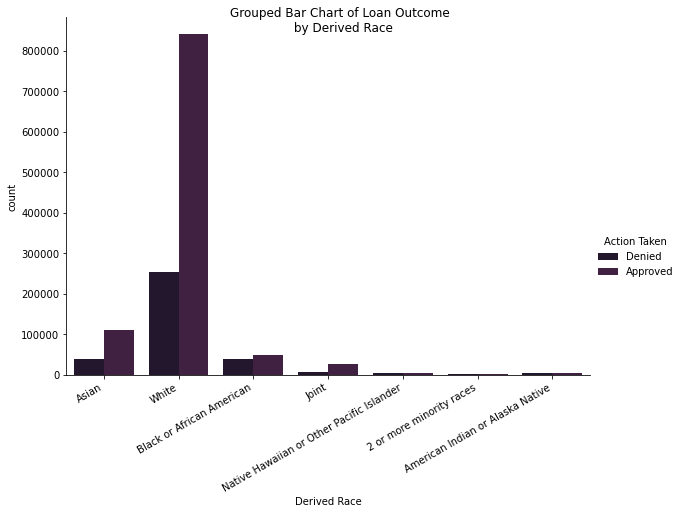

In [71]:
g4 = sns.catplot(x='derived_race', kind = "count", data=cont_data, 
                 legend_out = True, height = 5.5, aspect = 1.5, hue = 'action_taken')
g4.set_xticklabels(rotation=30, ha="right")
g4._legend.set_title('Action Taken')
plt.xlabel('Derived Race')
plt.suptitle("Grouped Bar Chart of Loan Outcome \n by Derived Race",  y = 1)

#for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

## Testing for difference in proportions

### Sex

In [72]:
cont_data = cont_data[cont_data.derived_sex != 'Joint']
cont_table = pd.crosstab(cont_data.derived_sex,cont_data.action_taken)
cont_table

action_taken,Approved,Denied
derived_sex,,
Female,217739,96518
Male,341274,134392


In [73]:
pd.crosstab(cont_data.action_taken, cont_data.derived_sex).apply(lambda r:r/r.sum(),axis=0)

derived_sex,Female,Male
action_taken,,
Approved,0.693,0.717
Denied,0.307,0.283


In [74]:
prop = cont_data.groupby("derived_sex")["action_taken"].agg([lambda z: np.mean(z=="Approved"), "size"])
prop.columns = ['proportions_approved','totals']

approved_prop = (cont_data.action_taken == "Approved").mean()

In [75]:
approved_prop = (cont_data.action_taken == "Approved").mean()
var = approved_prop * (1 - approved_prop)
SE = np.sqrt(var * (1 / prop.totals['Female'] + 1 / prop.totals['Male']))

b_est = (prop.proportions_approved.Female - prop.proportions_approved.Male)

h0_est = 0
test_stat = ((b_est-h0_est) / SE).round(2)
print("Z-statistic:",test_stat)

# p-value
pval = 2*dist.norm.cdf(-np.abs(test_stat)) 
print("P-value:", pval)

Z-statistic: -23.52
P-value: 2.546549412438578e-122


In [76]:
res_test = pd.crosstab(cont_data.action_taken, cont_data.derived_sex)

In [77]:
count = np.array([res_test['Female']['Approved'], res_test['Male']['Approved']])
nobs = np.array([res_test['Female'].sum(), res_test['Male'].sum()])
stat, pval = proportions_ztest(count, nobs)
print(pval)

2.2763010656611945e-122


In [78]:
count = np.array([res_test['Female']['Approved'], res_test['Male']['Approved']])
nobs = np.array([res_test['Female'].sum(), res_test['Male'].sum()])
stat, pval = proportions_ztest(count, nobs, value =0.0, alternative = 'smaller')
print('Upper Tailed P-value:',pval)
print('Upper Tailed Z-statistic:',stat)

Upper Tailed P-value: 1.1381505328305972e-122
Upper Tailed Z-statistic: -23.52476081982678


### Race

In [79]:
cont_data_race = cont_data[cont_data.derived_race != 'Joint']

In [80]:
cont_table_race = pd.crosstab(cont_data_race.action_taken,cont_data_race.derived_race)
cont_table_race.apply(lambda r:r/r.sum(),axis=0)

derived_race,2 or more minority races,American Indian or Alaska Native,Asian,Black or African American,Native Hawaiian or Other Pacific Islander,White
action_taken,,,,,,
Approved,0.440,0.448,0.715,0.542,0.354,0.732
Denied,0.560,0.552,0.285,0.458,0.646,0.268


In [81]:
chi_2_results = chi2_contingency(cont_table_race)
chi, pvalue, dof, exp = chi2_contingency(cont_table_race)

In [82]:
cont_table_race.columns

Index(['2 or more minority races', 'American Indian or Alaska Native', 'Asian',
       'Black or African American',
       'Native Hawaiian or Other Pacific Islander', 'White'],
      dtype='object', name='derived_race')

In [83]:
pd.DataFrame(chi_2_results[3],
             index=['Approved','Denied'],
             columns=[cont_table_race.columns])

derived_race,2 or more minority races,American Indian or Alaska Native,Asian,Black or African American,Native Hawaiian or Other Pacific Islander,White
Approved,1569.432,4863.964,66966.893,47949.034,4440.119,431937.558
Denied,648.568,2010.036,27674.107,19814.966,1834.881,178498.442


In [84]:
significance = 0.1
p = 1 - significance
dof = chi_2_results[2]
critical_value = chi2.ppf(p, dof)

In [85]:
print('P-value is:', pvalue)
print('Chi Squared Statistic = %.6f\nCritical Value = %.6f\n' % (chi, critical_value))

P-value is: 0.0
Chi Squared Statistic = 17558.332606
Critical Value = 9.236357



## Encoding and Scaling

In [86]:
data.to_csv('applications_cleaned.csv')

In [87]:
data = pd.get_dummies(data)

In [88]:
data_copy = data.copy()

data = preprocessing.MinMaxScaler().fit_transform(data)

In [89]:
print(data.shape)
target.shape

(1383252, 26)


(1383252,)

In [90]:
pd.DataFrame(data, columns=data_copy.columns).sample(5, random_state=999)

,loan_amount,income,derived_ethnicity_Hispanic or Latino,derived_ethnicity_Joint,derived_ethnicity_Not Hispanic or Latino,derived_race_2 or more minority races,derived_race_American Indian or Alaska Native,derived_race_Asian,derived_race_Black or African American,derived_race_Joint,derived_race_Native Hawaiian or Other Pacific Islander,derived_race_White,derived_sex_Female,derived_sex_Joint,derived_sex_Male,loan_type_1,loan_type_2,loan_type_3,loan_type_4,applicant_age_25-34,applicant_age_35-44,applicant_age_45-54,applicant_age_55-64,applicant_age_65-74,applicant_age_<25,applicant_age_>74
824843,0.350,0.063,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
538913,0.285,0.066,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
602981,0.163,0.024,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
1013829,0.366,0.073,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
218448,0.081,0.063,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000


## Feature Selection

### All Features

In [91]:
clf = DecisionTreeClassifier(random_state=999)

cv_method = RepeatedStratifiedKFold(n_splits=3, 
                                    n_repeats=2,
                                    random_state=999)
scoring_metric = 'accuracy'

In [92]:
start_time = time.time()

cv_results_all = cross_val_score(estimator=clf,
                             X=data,
                             y=target, 
                             cv=cv_method, 
                             n_jobs = 2,
                             scoring=scoring_metric)

print("--- %s seconds ---" % (time.time() - start_time))

print(cv_results_all.mean().round(5))

cv_results_all

--- 25.679020404815674 seconds ---
0.76572


array([0.76571948, 0.76531825, 0.7656349 , 0.76541801, 0.76640048,
       0.76585178])

### Random Forest Importance

In [93]:
num_features = 10

In [94]:
start_time = time.time()

model_rfi = RandomForestClassifier(n_estimators=100)
model_rfi.fit(data, target)
fs_indices_rfi = np.argsort(model_rfi.feature_importances_)[::-1][0:num_features]

print("--- %s seconds ---" % (time.time() - start_time))

--- 280.39093041419983 seconds ---


In [95]:
best_features_rfi = data_copy.columns[fs_indices_rfi].values
best_features_rfi

array(['income', 'loan_amount', 'applicant_age_25-34',
       'derived_race_White', 'derived_race_Black or African American',
       'derived_ethnicity_Hispanic or Latino', 'derived_sex_Joint',
       'derived_ethnicity_Not Hispanic or Latino', 'applicant_age_35-44',
       'applicant_age_>74'], dtype=object)

In [96]:
feature_importances_rfi = model_rfi.feature_importances_[fs_indices_rfi]
feature_importances_rfi

array([0.45896545, 0.44600568, 0.01634115, 0.01075504, 0.00758988,
       0.00699345, 0.00685081, 0.00588912, 0.0051462 , 0.00371516])

In [97]:
def plot_imp(best_features, scores, method_name):   
    plt.barh(best_features, scores)
    plt.title(method_name + ' Feature Importance', x=0.15)
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()

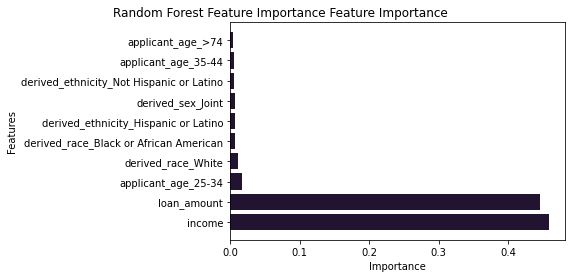

In [98]:
plot_imp(best_features_rfi, feature_importances_rfi, 'Random Forest Feature Importance')

In [99]:
start_time = time.time()

cv_results_rfi = cross_val_score(estimator=clf,
                             X=data[:, fs_indices_rfi],
                             y=target, 
                             cv=cv_method, 
                             n_jobs = 2,
                             scoring=scoring_metric)

print("--- %s seconds ---" % (time.time() - start_time))

cv_results_rfi.mean().round(5)

--- 12.152587413787842 seconds ---


0.78201

In [100]:
cv_results_rfi

array([0.78183585, 0.78139124, 0.78214599, 0.78162547, 0.78265999,
       0.78240407])

## Feature Selection Using F Score

In [101]:
num_features = 10

fs_fit_fscore = fs.SelectKBest(fs.f_classif, k=num_features)

fs_fit_fscore.fit_transform(data, target)

fs_indices_fscore = np.argsort(np.nan_to_num(fs_fit_fscore.scores_))[::-1][0:num_features]

In [102]:
best_features_fscore = data_copy.columns[fs_indices_fscore].values
best_features_fscore

array(['loan_amount', 'applicant_age_25-34', 'income',
       'derived_race_Black or African American',
       'derived_ethnicity_Hispanic or Latino', 'derived_sex_Joint',
       'derived_ethnicity_Not Hispanic or Latino', 'derived_race_White',
       'applicant_age_>74', 'applicant_age_55-64'], dtype=object)

In [103]:
feature_importances_fscore = fs_fit_fscore.scores_[fs_indices_fscore]
feature_importances_fscore

array([121151.37818666,  24907.69341967,  19358.47710449,  17695.89138089,
        16298.79873953,  15025.48795794,  14131.46436406,  12590.77649458,
         6594.94587142,   6321.37499705])

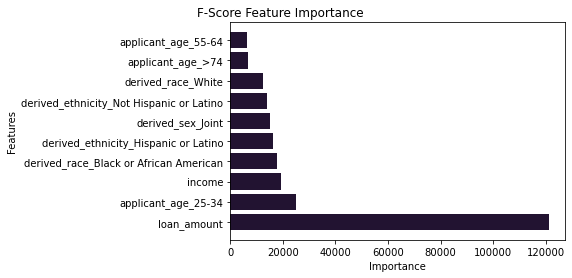

In [104]:
plot_imp(best_features_fscore, feature_importances_fscore, 'F-Score')

In [105]:
data[:, fs_indices_fscore].shape

(1383252, 10)

In [106]:
start_time = time.time()
cv_results_fscore = cross_val_score(estimator=clf,
                             X=data[:, fs_indices_fscore],
                             y=target,
                             n_jobs = 2,
                             cv=cv_method, 
                             scoring=scoring_metric)

print("--- %s seconds ---" % (time.time() - start_time))

cv_results_fscore.mean().round(5)

--- 14.832571029663086 seconds ---


0.78159

In [107]:
data[:, fs_indices_fscore].shape

(1383252, 10)

## Hyperparameter Tuning

### KNN Tuning

In [108]:
num_samples = 100000
data_sample = pd.DataFrame(data).sample(n=num_samples, random_state=999).values
target_sample = pd.DataFrame(target).sample(n=num_samples, random_state=999).values

print(data_sample.shape)
print(target_sample.shape)

(100000, 26)
(100000, 1)


In [109]:
train_data, test_data, \
train_target, test_target = train_test_split(data_sample, target_sample, 
                                                    test_size = 0.3, random_state=999,
                                                    stratify = target_sample)

print(train_data.shape)
print(test_data.shape)
print(train_target.shape)
print(test_target.shape)

(70000, 26)
(30000, 26)
(70000, 1)
(30000, 1)


In [110]:
def get_search_results(gs):

    def model_result(scores, params):
        scores = {'mean_score': np.mean(scores),
             'std_score': np.std(scores),
             'min_score': np.min(scores),
             'max_score': np.max(scores)}
        return pd.Series({**params,**scores})

    models = []
    scores = []

    for i in range(gs.n_splits_):
        key = f"split{i}_test_score"
        r = gs.cv_results_[key]        
        scores.append(r.reshape(-1,1))

    all_scores = np.hstack(scores)
    for p, s in zip(gs.cv_results_['params'], all_scores):
        models.append((model_result(s, p)))

    pipe_results = pd.concat(models, axis=1).T.sort_values(['mean_score'], ascending=False)

    columns_first = ['mean_score', 'std_score', 'max_score', 'min_score']
    columns = columns_first + [c for c in pipe_results.columns if c not in columns_first]

    return pipe_results[columns]

In [111]:
pipe_knn = Pipeline([('fscore', SelectKBest()),
                     ('knn', KNeighborsClassifier())])

params = {'fscore__score_func':[f_classif],
          'fscore__k': [5,10,20],
          'knn__n_neighbors':([5,10,25,50]),
          'knn__p': [1, 2]}

KNN_model = GridSearchCV(pipe_knn, 
                         params,
                         cv=cv_method,
                         n_jobs=2,
                         scoring=scoring_metric,
                         verbose=1)

start_time = time.time()
KNN_model.fit(train_data, train_target.ravel())
print("--- %s seconds ---" % (time.time() - start_time))

print(KNN_model.best_score_)
print(KNN_model.best_params_)

Fitting 6 folds for each of 24 candidates, totalling 144 fits
--- 814.691032409668 seconds ---
0.8050428625734094
{'fscore__k': 5, 'fscore__score_func': <function f_classif at 0x000002118EBEDC18>, 'knn__n_neighbors': 25, 'knn__p': 2}


In [112]:
KNN_model.score(test_data, test_target)

0.8103666666666667

### NB Tuning

In [113]:
train_data_pwr = PowerTransformer().fit_transform(data_copy)

NB_data_sample = pd.DataFrame(train_data_pwr).sample(n=num_samples, random_state=999).values
NB_target_sample = pd.DataFrame(target).sample(n=num_samples, random_state=999).values

print(NB_data_sample.shape)
print(NB_target_sample.shape)

(100000, 26)
(100000, 1)


In [114]:
NB_train_data, NB_test_data, \
NB_train_target, NB_test_target = train_test_split(NB_data_sample, NB_target_sample, 
                                                    test_size = 0.3, random_state=999,
                                                    stratify = NB_target_sample)

print(NB_train_data.shape)
print(NB_test_data.shape)
print(NB_train_target.shape)
print(NB_test_target.shape)

(70000, 26)
(30000, 26)
(70000, 1)
(30000, 1)


In [115]:
class RFIFeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, n_features_=10):
        self.n_features_ = n_features_
        self.fs_indices_ = None

    def fit(self, X, y):
        model_rfi = RandomForestClassifier(n_estimators=100)
        model_rfi.fit(X, y)
        self.fs_indices_ = argsort(model_rfi.feature_importances_)[::-1][0:self.n_features_] 
        return self 
    
    def transform(self, X, y=None):
        return X[:, self.fs_indices_]

In [116]:
pipe_NB = Pipeline([('fscore', SelectKBest()),
                     ('nb', GaussianNB())])

params_pipe_NB = {'fscore__k': [5,10,20],
                  'nb__var_smoothing': np.logspace(0,1, num=50)}

NB_model = GridSearchCV(estimator=pipe_NB, 
                          param_grid=params_pipe_NB, 
                          cv=cv_method,
                          n_jobs=2,
                          scoring=scoring_metric,
                          
                          verbose=1) 

start_time = time.time()
NB_model.fit(NB_train_data, NB_train_target.ravel());
print("--- %s seconds ---" % (time.time() - start_time))

Fitting 6 folds for each of 150 candidates, totalling 900 fits
--- 30.162917137145996 seconds ---


In [117]:
NB_model.best_params_

{'fscore__k': 10, 'nb__var_smoothing': 1.676832936811008}

In [118]:
NB_model.best_estimator_

Pipeline(steps=[('fscore', SelectKBest()),
                ('nb', GaussianNB(var_smoothing=1.676832936811008))])

In [119]:
NB_model.best_score_

0.7656928443943425

In [120]:
get_search_results(NB_model)

,mean_score,std_score,max_score,min_score,fscore__k,nb__var_smoothing
61,0.766,0.002,0.768,0.763,10.000,1.677
62,0.766,0.002,0.767,0.763,10.000,1.758
60,0.765,0.002,0.769,0.762,10.000,1.600
59,0.765,0.002,0.769,0.762,10.000,1.526
108,0.765,0.002,0.768,0.763,20.000,1.456
...,...,...,...,...,...,...
33,0.745,0.000,0.745,0.745,5.000,4.715
47,0.745,0.000,0.745,0.745,5.000,9.103
45,0.745,0.000,0.745,0.745,5.000,8.286
49,0.745,0.000,0.745,0.745,5.000,10.000


In [121]:
NB_model.score(NB_test_data, NB_test_target)

0.7673666666666666

### Decsion Tree Tuning

In [122]:
DT_pipe = Pipeline([('fscore', SelectKBest()),
                    ('dt', DecisionTreeClassifier(criterion='gini', random_state=999))])

DT_pipe_params = {'fscore__k': [5,10,20],
                  'dt__max_depth': [3,4,5],
                  'dt__min_samples_split': [2, 5]}

DT_model = GridSearchCV(estimator=DT_pipe, 
                          param_grid=DT_pipe_params, 
                          cv=cv_method,
                          refit=True,
                          n_jobs=2,
                          scoring=scoring_metric,
                          verbose=1) 

start_time = time.time()
DT_model.fit(train_data, train_target.ravel());
print("--- %s seconds ---" % (time.time() - start_time))

Fitting 6 folds for each of 18 candidates, totalling 108 fits
--- 4.149836540222168 seconds ---


In [123]:
DT_model.best_params_

{'dt__max_depth': 5, 'dt__min_samples_split': 2, 'fscore__k': 5}

In [124]:
DT_model.best_estimator_

Pipeline(steps=[('fscore', SelectKBest(k=5)),
                ('dt', DecisionTreeClassifier(max_depth=5, random_state=999))])

In [125]:
DT_model.best_score_

0.807335730431335

In [126]:
get_search_results(DT_model).head()

,mean_score,std_score,max_score,min_score,dt__max_depth,dt__min_samples_split,fscore__k
15,0.807,0.002,0.810,0.805,5.000,5.000,5.000
12,0.807,0.002,0.810,0.805,5.000,2.000,5.000
16,0.807,0.002,0.811,0.805,5.000,5.000,10.000
13,0.807,0.002,0.811,0.805,5.000,2.000,10.000
17,0.807,0.002,0.810,0.805,5.000,5.000,20.000


In [127]:
DT_model.score(test_data, test_target)

0.8107

## Final Model - Decision Tree

In [128]:
pipe_DT = Pipeline([('fscore', SelectKBest()),
                    ('dt', DecisionTreeClassifier(criterion='gini', random_state=999))])

params_pipe_DT = {'fscore__k': [10],
                  'dt__max_depth': [5],
                  'dt__min_samples_split': [2]}

In [129]:
DT_Model_full = GridSearchCV(estimator=pipe_DT, 
                          param_grid=params_pipe_DT, 
                          cv=cv_method,
                          refit=True,
                          n_jobs=-1,
                          scoring=scoring_metric,
                          verbose=1) 

In [130]:
start_time = time.time()
DT_Model_full.fit(data, target);
print("--- %s seconds ---" % (time.time() - start_time))

Fitting 6 folds for each of 1 candidates, totalling 6 fits
--- 9.786816835403442 seconds ---


In [131]:
DT_Model_full.best_params_

{'dt__max_depth': 5, 'dt__min_samples_split': 2, 'fscore__k': 10}

In [132]:
DT_Model_full.best_score_

0.8115184362646864

In [133]:
prediction_data_refined = data_copy.values[0:5,]

In [134]:
prediction_data = preprocessing.MinMaxScaler().fit_transform(prediction_data_refined)

In [135]:
DT_Model_full.predict(prediction_data)

array([0, 1, 1, 1, 1], dtype=int64)

In [136]:
target[0:5]

36    0
38    1
41    1
43    1
46    1
Name: action_taken, dtype: int64